# Total Cost Prediction
This notebook explores the [Hospital Inpatient Discharges](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/82xm-y6g8) dataset, attempting to predict the total estimated cost of care. This dataset is de-identified, meaning no identifiable information is included and it can be used for public projects. These observations were taken from the discharge year 2015 in the state of New York and were released by the New York State Department of Health. 

This data was downloaded on February 13th, 2020 and totaled around 900Mb on disk.

In [1]:
# imports
import numpy as np
import pandas as pd

from scipy.stats import f_oneway, chi2_contingency

import matplotlib.pyplot as plt

# show all jupyter notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [2]:
# h2o imports
import h2o
from h2o.sklearn import H2OAutoMLRegressor

## Cleaning
Before we dive into modeling, let's take some time to clean up the data set. First, we will load up the dataset into a pandas dataframe and run some basic summary statistics.

In [3]:
datapath = "data/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv"
full_dataset = pd.read_csv(datapath)
full_dataset.shape
full_dataset.columns
full_dataset.head()

C:\Users\compu\anaconda3\envs\empiric\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2346931, 34)

Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility Id', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5333.90,4818.42
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,NaN,NaN,0,N,Y,4865.99,4588.78
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5901.54,5559.56
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,NaN,NaN,0,N,Y,3619.08,3567.25
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,Blue Cross/Blue Shield,Private Health Insurance,0,N,Y,3185.87,3167.89


2.3 million rows is quite a lot - that might cause some performance issues down the road. However, this tidbit gives us quite a bit of information up front, including the column names. The "Total Costs" column is the one we are predicting, with most of the rest being our feature columns. We can throw out a few columns immediately:
 * Description columns - we will print the shorter ones for reference, but these won't add any value:
  * Facility ID (we will use name for interpretability later on)
  * Operating Certificate Number (proxy for facility ID according to the data description)
  * CCS Diagnosis Description
  * CCS Procedure Description
  * APR DRG Description
  * APR MDC Description
  * APR Severity of Illness Description
 * Abortion edit indicator - we will use this column for another purpose later on, so I won't be dropping it just yet but will later on.
 * Discharge Year - all 2015
 * Total Charges - it was unclear in the documentation how this relates to Total Costs, so I'm assuming it's a proxy and throwing it out


First, let's validate that last assumption:

Pearson Correlation


,Total Charges,Total Costs
Total Charges,1.00000,0.90176
Total Costs,0.90176,1.00000


<AxesSubplot:xlabel='Total Costs', ylabel='Total Charges'>

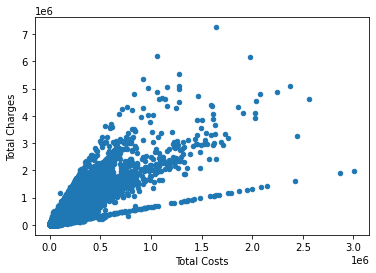

In [4]:
print("Pearson Correlation")
full_dataset[["Total Charges", "Total Costs"]].corr()
full_dataset.plot(kind="scatter", x="Total Costs", y="Total Charges")

In [5]:
full_dataset["Discharge Year"].value_counts()

2015    2346931
Name: Discharge Year, dtype: int64

Like I said, they seemed to be proxies of each other. I feel that we can safely throw out this variable. The other descriptor variables are listed in the "Codes Reference" notebook.

In [6]:
# drop the variables
dropped_cols = ["Facility Id", "Operating Certificate Number", "CCS Diagnosis Description", "CCS Procedure Description",
                "APR DRG Description", "APR MDC Description", "APR Severity of Illness Description", "Discharge Year",
                "Total Charges"]
trimmed_dataset = full_dataset.drop(dropped_cols, axis=1)

Next, we need to define the data types of our predictor variables - mainly expressly turning categorical variables into categories. This will help in performance later on. We will start with the obvious ones:

In [7]:
category_list = [
    "Health Service Area",
    "Hospital County",
    "Facility Name",
    "Age Group",
    "Zip Code - 3 digits",
    "Gender",
    "Race", 
    "Ethnicity",
    "Type of Admission",
    "Patient Disposition",
    "CCS Diagnosis Code",
    "CCS Procedure Code",
    "APR DRG Code",
    "APR MDC Code",
    "APR Severity of Illness Code",
    "APR Risk of Mortality",
    "APR Medical Surgical Description",
    "Payment Typology 1",
    "Payment Typology 2",
    "Payment Typology 3",
    "Emergency Department Indicator"
]

category_map = {cat: "category" for cat in category_list}
trimmed_dataset = trimmed_dataset.astype(category_map)

Length of stay should be numerical, but if a stay is greater than 120 days then it is truncated to 120 +. Given the unlikely nature of that, it's fine to just force that to be 120.

In [8]:
trimmed_dataset["Length of Stay"] = trimmed_dataset["Length of Stay"].apply(lambda x: 120 if x == "120 +" else int(x)).astype("int32")

In [9]:
# fill some NAs
trimmed_dataset.isna().sum(axis=0)

Health Service Area                    5464
Hospital County                        5464
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   35816
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
Patient Disposition                       0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                   111
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   762285
Payment Typology 3                  1645513
Birth Weight                              0
Abortion Edit Indicator         

In [10]:
# only filling a few of these - you will see why later
trimmed_dataset["APR Risk of Mortality"].cat.add_categories("None", inplace=True)
trimmed_dataset["APR Risk of Mortality"] = trimmed_dataset["APR Risk of Mortality"].fillna("None")

In [11]:
trimmed_dataset["Payment Typology 2"].cat.add_categories("None", inplace=True)
trimmed_dataset["Payment Typology 2"] = trimmed_dataset["Payment Typology 2"].fillna("None")
trimmed_dataset["Payment Typology 3"].cat.add_categories("None", inplace=True)
trimmed_dataset["Payment Typology 3"] = trimmed_dataset["Payment Typology 3"].fillna("None")

In [12]:
# Birthweight can be left as is, so we end up with the following feature list:
feature_list = category_list + ["Length of Stay", "Birth Weight"]
feature_list

['Health Service Area',
 'Hospital County',
 'Facility Name',
 'Age Group',
 'Zip Code - 3 digits',
 'Gender',
 'Race',
 'Ethnicity',
 'Type of Admission',
 'Patient Disposition',
 'CCS Diagnosis Code',
 'CCS Procedure Code',
 'APR DRG Code',
 'APR MDC Code',
 'APR Severity of Illness Code',
 'APR Risk of Mortality',
 'APR Medical Surgical Description',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Emergency Department Indicator',
 'Length of Stay',
 'Birth Weight']

Note that we still haven't done anything with the Abortion Edit Indicator field. This field marks whether or not information has been redacted because of an abortion, as per state law. Redacted information includes the following:
 * Health Service Area
 * Hospital County
 * Facility Name
 * Zip Code

Normally, I would try and find some way around these blanked records - either by putting abortion patients into a separate cohort and training a different model or removing those patients from the dataset entirely; however, for the sake of time, we will simply remove those columns and move forward. It's a shame, as it would be interesting to examine costs as a factor of geographic location and facility.

In [13]:
drop_cols = ["Health Service Area", "Hospital County", "Facility Name", "Zip Code - 3 digits", "Abortion Edit Indicator"]
category_list = [col for col in category_list if col not in drop_cols]
feature_list = category_list + ["Length of Stay", "Birth Weight"]
feature_list
len(feature_list)

['Age Group',
 'Gender',
 'Race',
 'Ethnicity',
 'Type of Admission',
 'Patient Disposition',
 'CCS Diagnosis Code',
 'CCS Procedure Code',
 'APR DRG Code',
 'APR MDC Code',
 'APR Severity of Illness Code',
 'APR Risk of Mortality',
 'APR Medical Surgical Description',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Emergency Department Indicator',
 'Length of Stay',
 'Birth Weight']

19

This has reduced our potential feature list from 33 features to 19 - that's a reasonable number, especially since most of them are categorical. 

## Holdout Set Creation
Before we get into any feature analysis, let's go ahead and create a holdout set that we can report our results on. By creating this now, we make sure that we aren't biased at all by the holdout set.

In [14]:
train_X, test_X, train_y, test_y = train_test_split(trimmed_dataset[feature_list], trimmed_dataset["Total Costs"], train_size=0.8)
train_X.shape
train_X.head()

(1877544, 19)

,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Length of Stay,Birth Weight
872704,50 to 69,M,White,Not Span/Hispanic,Emergency,Home or Self Care,122,0,139,4,2,Minor,Medical,Medicaid,Self-Pay,Self-Pay,Y,1,0
1198712,70 or Older,F,White,Not Span/Hispanic,Emergency,Skilled Nursing Home,143,231,227,6,3,Major,Surgical,Medicare,Medicaid,None,Y,7,0
1725014,0 to 17,F,Other Race,Not Span/Hispanic,Newborn,Home or Self Care,218,228,640,15,1,Minor,Medical,Blue Cross/Blue Shield,Self-Pay,None,N,3,2500
358856,70 or Older,M,White,Not Span/Hispanic,Emergency,Home or Self Care,129,0,137,4,2,Major,Medical,Medicare,Private Health Insurance,Self-Pay,Y,4,0
825601,50 to 69,F,Black/African American,Unknown,Emergency,Home or Self Care,93,0,111,3,1,Minor,Medical,Medicare,Medicare,Medicaid,Y,2,0


## Exploratory Data Analysis

Let's do a bit of digging into these features, starting with the most popular values for each of the categorical values.

In [15]:
top_5_popular_vals = [train_X[col].value_counts(dropna=False).reset_index().head(5)["index"].rename(col) for col in category_list]
pd.concat(top_5_popular_vals, axis=1)

,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator
0,50 to 69,F,White,Not Span/Hispanic,Emergency,Home or Self Care,218,0,640,5,2,Minor,Medical,Medicare,None,None,Y
1,70 or Older,M,Other Race,Spanish/Hispanic,Elective,Home w/ Home Health Services,2,231,560,14,1,Moderate,Surgical,Medicaid,Medicaid,Self-Pay,N
2,30 to 49,U,Black/African American,Unknown,Newborn,Skilled Nursing Home,203,137,720,15,3,Major,Not Applicable,Private Health Insurance,Self-Pay,Medicaid,NaN
3,0 to 17,NaN,Multi-racial,Multi-ethnic,Urgent,Expired,108,228,540,8,4,Extreme,NaN,Blue Cross/Blue Shield,Medicare,Private Health Insurance,NaN
4,18 to 29,NaN,NaN,NaN,Trauma,Left Against Medical Advice,657,134,194,6,0,None,NaN,Self-Pay,Private Health Insurance,Blue Cross/Blue Shield,NaN


This is an interesting table - it gives us a peek into the different variables all at once without getting too specific. A few things to call out:
 * We primarily have ages 50-69 in our data set, and we can look into by how much later.
 * CCS 218 is Liveborn - this likely applies to all newborn stays. The second highest is Sepsis.
 * CCS 0 is no procedure.
 * The top few DRGs are birth DRGs
 * MCD 5 is circulatory diseases (likely heart failure)
 * The payment typology columns present an interesting challenge - given the number of nulls in the last two columns, that likely would be more informative as two sets of columns: Primary Payment Method and "Has X" where X is a type of payment.

Let's dig into a few more columns and see some distributions.

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Age Group')

Text(0, 0.5, 'Percentage of total')

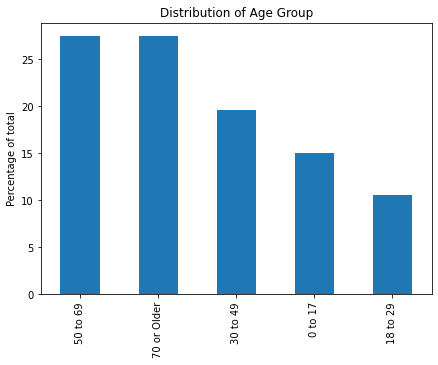

In [16]:
# age group
plt.subplot()
(train_X["Age Group"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Age Group")
plt.ylabel("Percentage of total")

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Gender')

Text(0, 0.5, 'Percentage of Total')

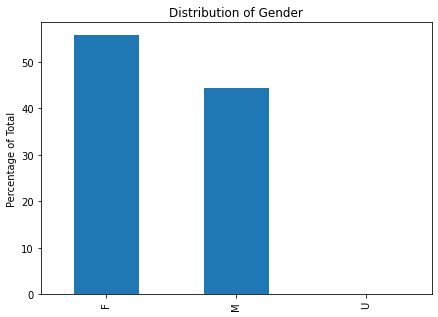

In [17]:
# gender
(train_X["Gender"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Gender")
plt.ylabel("Percentage of Total")

One thing to note - this distribution isn't unexpected. In other data sources that I've worked with (especially Medicare populations) women are represented in higher proportions.

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Race')

Text(0, 0.5, 'Percentage of Total')

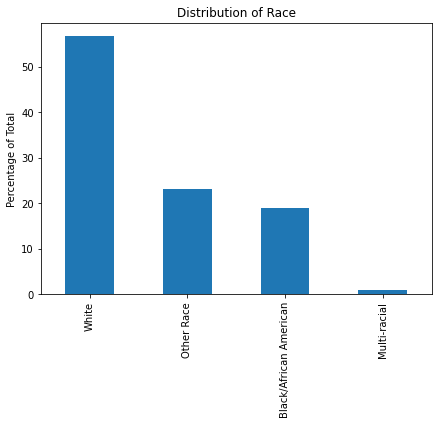

In [18]:
# race
(train_X["Race"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Race")
plt.ylabel("Percentage of Total")

Again, this also isn't surprising. For the sake of time, I will restrict myself to one more distribution - payment method. That will tell me a great deal about the general characteristics of the population.

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Primary Payment')

Text(0, 0.5, 'Percentage of Total')

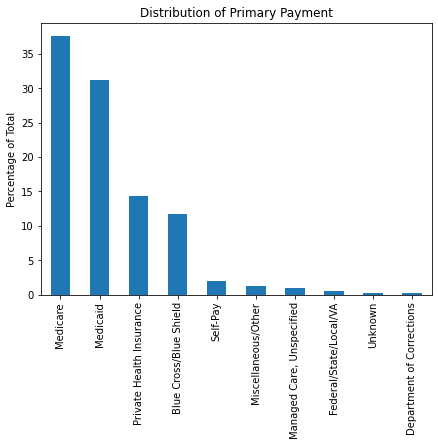

In [19]:
# Primary Payer
(train_X["Payment Typology 1"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Primary Payment")
plt.ylabel("Percentage of Total")

As I suspected - we have a high Medicare percentage here. This jives with the other graphs I have made so far - the M/F ratio is what I would expect from that type of population, as is the age distribution. Now that we have a general sense of the population we are working with, let's see how these variables compare with our target. We will start by correlating our numerical columns with the target.

In [20]:
pd.concat([train_X[["Length of Stay", "Birth Weight"]], train_y], axis=1).corr()

,Length of Stay,Birth Weight,Total Costs
Length of Stay,1.000000,-0.094463,0.713329
Birth Weight,-0.094463,1.000000,-0.117054
Total Costs,0.713329,-0.117054,1.000000


Length of stay seems to have a high correlation with our target - that makes a lot of sense (the longer you are at the hospital, the higher the bill would be expected to be). I anticipate that will be a useful column later on. For our categorical variables, we can use a one-way ANOVA to see if different categorical groups have statistically significantly different means. This will give us a sense of how much information is gained through each column, and with the F score we can get a measure of the information gained. Before we do, we should check normality:

<AxesSubplot:ylabel='Frequency'>

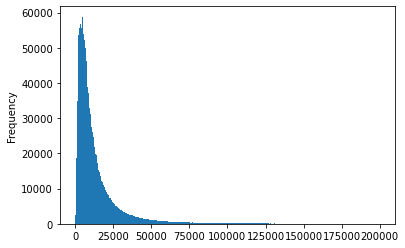

In [21]:
train_y[train_y < 200000].plot(kind="hist", bins=500)

Not perfect, but it's relatively close. We should be able to proceed.

In [22]:
# age as an example
groups = [group["Total Costs"].values for name, group in pd.concat([train_X, train_y], axis=1).groupby("Age Group")]
f_oneway(*groups)

F_onewayResult(statistic=8299.020732715215, pvalue=0.0)

In [23]:
for cat in category_list:
    groups = [group["Total Costs"].values for name, group in pd.concat([train_X, train_y], axis=1).groupby(cat)]
    F, p = f_oneway(*groups)
    print(f"{cat}: {F} (pvalue={p})")

Age Group: 8299.020732715215 (pvalue=0.0)
Gender: 1837.064091905654 (pvalue=0.0)
Race: 644.7665169625022 (pvalue=0.0)
Ethnicity: 347.7028640564287 (pvalue=9.250065986545426e-226)
Type of Admission: 4688.237139738321 (pvalue=0.0)
Patient Disposition: 7039.402478219278 (pvalue=0.0)
CCS Diagnosis Code: 655.5319860418549 (pvalue=0.0)
CCS Procedure Code: 2087.699756719894 (pvalue=0.0)
APR DRG Code: 2736.756632573342 (pvalue=0.0)
APR MDC Code: 3208.5632028797113 (pvalue=0.0)
APR Severity of Illness Code: 77170.00895906008 (pvalue=0.0)
APR Risk of Mortality: 54129.516370868376 (pvalue=0.0)
APR Medical Surgical Description: 53469.37551713241 (pvalue=0.0)
Payment Typology 1: 1765.5817331370104 (pvalue=0.0)
Payment Typology 2: 1375.6089971960532 (pvalue=0.0)
Payment Typology 3: 688.5119720782826 (pvalue=0.0)
Emergency Department Indicator: 87.88381230358888 (pvalue=6.948747962415132e-21)


A couple of observations we can make here:
 * Risk of Mortality, Illness Severity, and Med/Surg appear to be the most important. Mortality and Illness severity are likely proxies of the same thing, so both of them being high is to be expected.
 * Race, Ethnicity, CCS Diagnosis, Payment types 2 and 3, and EDI appear to be uninformative for stratification. CCS Diagnosis is really the only interesting one there - I expected that to have some predictive power due to it describing the state of the patient and the type of services that might have been provided.
 
With that out of the way, the last thing I want to check is the collinearity of a few of these problems - I have a feeling that a few of these features are proxies for eachother. We will start by computing a crosstab, then we can use a chi squared contingency test and Cramer's V to examine the correlation.

In [24]:
# expected low correlation
ct = pd.crosstab(index=train_X["Age Group"], columns=train_X["Race"])
chi2 = chi2_contingency(ct)[0]
mindim = min(ct.shape) - 1
cramers_v = np.sqrt((chi2/len(train_X)) / mindim)
cramers_v

0.11916201975237735

In [25]:
# I would expect slightly higher
ct = pd.crosstab(index=train_X["Ethnicity"], columns=train_X["Race"])
chi2 = chi2_contingency(ct)[0]
mindim = min(ct.shape) - 1
cramers_v = np.sqrt((chi2/len(train_X)) / mindim)
cramers_v

0.2549275744553108

In [26]:
# as I suspected - much more highly correlated
ct = pd.crosstab(index=train_X["APR Risk of Mortality"], columns=train_X["APR Severity of Illness Code"])
chi2 = chi2_contingency(ct)[0]
mindim = min(ct.shape) - 1
cramers_v = np.sqrt((chi2/len(train_X)) / mindim)
cramers_v

0.7041103367702699

I expected Risk of Mortality and Severity of Illness to be correlated - if I was performing the modeling, I would likely want to remove one or the other to avoid collinearity. However, I'm going to use H2O's AutoML to speed up finding the model. 

## Modeling
We are going to use H2O's AutoML to run some models. Before we do that, we will generate dummy variables on our categorical columns.

In [31]:
# set up the OHE
transformer_list = [(col+"_OHE", OneHotEncoder(handle_unknown="ignore"), [col]) for col in category_list]
onehot_transformer = ColumnTransformer(transformer_list, remainder="passthrough")

seed = 42
pipe = Pipeline([
    ("OHE", onehot_transformer),
    ("automl", H2OAutoMLRegressor(max_models = 10, seed = seed))
])

In [34]:
pipe.fit(train_X, pd.DataFrame(train_y))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
23:16:28.931: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████ (cancelled) 100%


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_9cd244fdfd4b6262b559903aa0ef47ef> was cancelled by the user.

<ipython-input-29-1edf85295eae>:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


H2O session _sid_a24c closed.
